<a href="https://colab.research.google.com/github/Maneekul/Image1/blob/main/Detect_Stew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import skimage.morphology as skmorph
from  skimage.measure import regionprops

In [2]:
def find_IoU(gt_img,output_img):
    intersect = np.logical_and(gt_img,output_img)
    union = np.logical_or(gt_img,output_img)
    IoU = np.sum(intersect) / np.sum(union)
    return IoU

def segmentConfusionMatrix(gt_img, output_img):
    matrix = confusion_matrix(gt_img.flatten(),output_img.flatten()).T
    con_matrix = np.zeros((matrix.shape[0]+1,matrix.shape[1]+1))
    con_matrix[:2,:2] = matrix

    prec_bg = matrix[0,0] / np.sum(matrix[0,:])
    prec_fg = matrix[1,1] / np.sum(matrix[1,:])
    con_matrix[:2,-1] = [prec_bg, prec_fg]

    rec_bg = matrix[0,0] / np.sum(matrix[:,0])
    rec_fg = matrix[1,1] / np.sum(matrix[:,1])
    con_matrix[-1,:2] = [rec_bg, rec_fg]

    accuracy =   (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    con_matrix[-1,-1] = accuracy

    return con_matrix

In [3]:
def fillhole(seg_img):
    mask = np.zeros((seg_img.shape[0]+2,seg_img.shape[1]+2),np.uint8)

    hole_img = seg_img.copy()

    cv2.floodFill(hole_img,mask,(0,0),1)
    hole_img = np.logical_not(hole_img)
    fill_img = np.logical_or(seg_img,hole_img)
    return fill_img

def dilateReconstruct(seed_img,mask_img, iteration):
    pre_img = seed_img

    for i in range(iteration):
        se = skmorph.disk(3)
        dialate_img = cv2.dilate(pre_img.astype(np.uint8),se)

        pre_img = np.logical_and(dialate_img,mask_img)

    output_img = pre_img

    return output_img

def erodeReconstruct(seed_img,mask_img, iteration):
    pre_img = seed_img

    for i in range(iteration):
        se = skmorph.disk(3)
        erode_img = cv2.erode(pre_img.astype(np.uint8),se)

        pre_img = np.logical_or(erode_img,mask_img)

    output_img = pre_img

    return output_img

def CCselectloop(label_img):
    min_size = int((label_img.shape[0]*label_img.shape[1])*0.0007) #0.00001

    labels , counts = np.unique(label_img,return_counts=True)

    output_img = label_img.copy()

    for y in range(label_img.shape[0]):
        for x in range(label_img.shape[1]):
            if counts[label_img[y,x]] >= min_size and label_img[y,x] != 0:
                output_img[y,x] = 1
            else:
                output_img[y,x] = 0
    return output_img

def mahalanobis(img2, center, cutoff):

    y,x,z = img2.shape

    positions = img2.reshape(y*x, z)
    centers = center*np.ones((y*x, 1))

    cov = np.cov(positions.T)
    inv_cov = np.linalg.inv(cov)

    delta = positions - centers
    distances = np.sqrt(np.einsum("ij, jk, ik->i", delta, inv_cov, delta))
    distances = distances.reshape((y,x))

    B = np.ones(img1.shape)
    B[distances>cutoff] = 0
    B[distances<=cutoff] = 1
    return B

In [4]:
def objectFeatures(close_img1):
    _,label_img1 = cv2.connectedComponents(close_img1)
    feature_vect = regionprops(label_img1)

    X = []
    obj_pos = []

    for i in range(len(feature_vect)):
        area = feature_vect[i].area
        eccen = feature_vect[i].bbox

        bbox = feature_vect[i].bbox

        X.append([area,eccen])
        obj_pos.append(bbox)

    return X, obj_pos

def classifierFeatures(X,close_img1):
    total_area = close_img1.shape[0]*close_img1.shape[1]

    y = []

    for i in range(len(X)):
        if ( X[i][0] >= 0.004*total_area): #X[i][0] >= 0.004*total_area or
            output_class = "A"
        else:
            output_class = "N"
        y.append(output_class)
    return y

def displayDetection(input_img,y,obj_pos):
    output_img1 = input_img.copy()

    for i in range(len(y)):
        if y[i] == "A":
            pos = obj_pos[i]
            output_img1 = cv2.rectangle(output_img1, (pos[1],pos[0]),(pos[3],pos[2]),(0,0,255),3)

            font = cv2.FONT_HERSHEY_SIMPLEX
            output_img1 = cv2.putText(output_img1, "STEWS" + y[i], (pos[1],pos[0]-10), font , 1.7, (0,0,255), 2)
    return output_img1

My_IOU =  0.4766485256927798
My_Confusion = 
[[9.50289400e+06 3.60936800e+06 7.24733383e-01]
 [2.31991000e+05 3.49856300e+06 9.37813258e-01]
 [9.76169107e-01 4.92205538e-01 7.71928934e-01]]


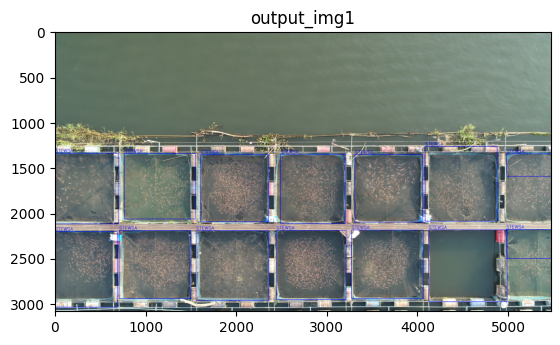

In [5]:
img = cv2.imread(r"/content/drive/MyDrive/Image_image/Fish_image/20 (4).JPG")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --> Read Groundtruth and convert to grayscale
gt_img = cv2.imread(r"/content/drive/MyDrive/Image_image/Stew_Ground/20 (4)_GT.jpg")
gt_img = cv2.cvtColor(gt_img,cv2.COLOR_BGR2GRAY)
# --> Round gray into white
gt_img = np.where(gt_img > 100, 1, 0)

seg_img = mahalanobis(img2,(190,50,50),3.7)
seg_img = seg_img.astype(np.uint8)

se = skmorph.disk(8)
seed_img = cv2.erode(seg_img.astype(np.uint8),se)
recon_img = dilateReconstruct(seed_img,seg_img,30)
recon_img = recon_img.astype(np.uint8)

hill_img = fillhole(recon_img)
hill_img = hill_img.astype(np.uint8)

_, label_img = cv2.connectedComponents(hill_img)
output_img = CCselectloop(label_img)

output_img = output_img.astype(np.uint8)
close_img1= fillhole(output_img)
close_img1 = close_img1.astype(np.uint8)

#plt.imshow(close_img1,cmap="gray")
#plt.title("close_img1")
#plt.show()

# ==> My Disply value
My_IOU = find_IoU(gt_img,close_img1)
print("My_IOU = ",My_IOU)
My_Confusion = segmentConfusionMatrix(gt_img, close_img1)
print("My_Confusion = ")
print(My_Confusion)

_, label_img1 = cv2.connectedComponents(close_img1)

feature_vect = regionprops(label_img1)
for i in range(len(feature_vect)):
    obj = feature_vect[i].image
    #plt.imshow(obj,cmap="gray")
    #plt.show()

# classifier and detection
X, obj_pos = objectFeatures(close_img1)
y = classifierFeatures(X,close_img1)
output_img1 =  displayDetection(img,y,obj_pos)
plt.imshow(output_img1,cmap="gray")
plt.title("output_img1")
plt.show()